# Lab 2 - Part A : The Global Race for AI Dominance

In this lab, we will use [artifical intelligence patent dataset](https://www.uspto.gov/ip-policy/economic-research/research-datasets/artificial-intelligence-patent-dataset) provided by USPTO to understand he determinants and impacts of artificial intelligence (AI) invention, and the global race for AI dominance.

In [1]:
library(pacman)
# vtree: sudo apt-get install libcairo2-dev librsvg2-dev
# https://yulab-smu.top/treedata-book/index.html
p_load(readxl, stringr, data.table, magrittr, ggplot2, SPARQL,
        eurostat, XML, RCurl, knitr, vtree, pheatmap)

# color palette
gray_scale <- c('#F3F4F8','#D2D4DA', '#B3B5BD', 
                '#9496A1', '#7d7f89', '#777986', 
                '#656673', '#5B5D6B', '#4d505e',
                '#404352', '#2b2d3b', '#282A3A',
                '#1b1c2a', '#191a2b',
                '#141626', '#101223')

ft_palette <- c('#990F3D', '#0D7680', '#0F5499', '#262A33', '#FFF1E5')

ft_contrast <- c('#F83', '#00A0DD', '#C00', '#006F9B', '#F2DFCE', '#FF7FAA',
                 '#00994D', '#593380')

peep_head <- function(dt, n = 5) {
    dt %>%
        head(n) %>%
        kable()
}

peep_sample <- function(dt, n = 5) {
    dt %>%
        .[sample(.N, n)] %>%
        kable()
}

peep_tail <- function(dt, n = 5) {
    dt %>%
        tail(n) %>%
        kable()
}

In [2]:
aipatents <- fread(cmd = 'unzip -p ../data/ai_model_predictions.tsv.zip ai_model_predictions.tsv')

In [6]:
# 13 million rows, 31 columns
dim(aipatents)

[1] 13244037       31

In [5]:
head(aipatents)

doc_id,flag_patent,pub_dt,appl_id,flag_train_any,predict50_any_ai,flag_train_ml,ai_score_ml,predict50_ml,flag_train_evo,⋯,flag_train_kr,ai_score_kr,predict50_kr,flag_train_planning,ai_score_planning,predict50_planning,flag_train_hardware,ai_score_hardware,predict50_hardware,analysis_phase
<chr>,<int>,<IDate>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,⋯,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>
20170299591,0,2017-10-19,15377054,0,0,0,0.0002722740,0,0,⋯,0,0.0013027191,0,0,0.0096018314,0,0,0.0023749471,0,1
20170128481,0,2017-05-11,14795790,0,0,0,0.0008636713,0,0,⋯,0,0.0009791255,0,0,0.0008031130,0,0,0.0002642870,0,1
20040254117,0,2004-12-16,09908955,0,0,0,0.0008810759,0,0,⋯,0,0.0003645420,0,0,0.0004195571,0,0,0.0011342168,0,1
20160167428,0,2016-06-16,14160226,0,0,0,0.0019406676,0,0,⋯,0,0.0003758669,0,0,0.0026210546,0,0,0.0005974174,0,1
RE38534,1,2004-06-15,10010151,0,0,0,0.0001583099,0,0,⋯,0,0.0020163655,0,0,0.0005110502,0,0,0.0011628866,0,1
RE38199,1,2003-07-22,10092912,0,0,0,0.0005730987,0,0,⋯,0,0.0006358624,0,0,0.0002709627,0,0,0.0008842945,0,1


In [10]:
# only get patents
aipatents %>%
    .[flag_patent == 1] %>%
    dim()  # only 6.9 million rows left

[1] 6920965      31

In [14]:
# only get patents with and predict50_any_ai == 1
aipatents %>%
    .[flag_patent == 1 & predict50_any_ai == 1] %>%
    str()  # only 6.7 thousand rows left

Classes ‘data.table’ and 'data.frame':	668808 obs. of  31 variables:
 $ doc_id             : chr  "4039258" "4178918" "4084816" "4028686" ...
 $ flag_patent        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ pub_dt             : IDate, format: "1977-08-02" "1979-12-18" ...
 $ appl_id            : chr  "05669500" "05833608" "05697725" "05684564" ...
 $ flag_train_any     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ predict50_any_ai   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ flag_train_ml      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ai_score_ml        : num  0.001178 0.010346 0.000421 0.008526 0.061306 ...
 $ predict50_ml       : int  0 0 0 0 0 0 0 1 1 0 ...
 $ flag_train_evo     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ai_score_evo       : num  0.005016 0.009261 0.000357 0.003412 0.001302 ...
 $ predict50_evo      : int  0 0 0 0 0 0 0 0 0 0 ...
 $ flag_train_nlp     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ai_score_nlp       : num  0.000574 0.008563 0.178022 0.00094 0.005659 ...
 $ predict50_nlp      : int  0 0 0 0 0 0 0 1 0 0 ...
 $

In [81]:
# check distribution of category
aipatents %>%
    .[flag_patent == 1 & predict50_any_ai == 1] %>%
    # only keep rows that include 'predict50' in the column name
    # and doc_id, appl_id, and pub_dt
    .[, .SD, .SDcols = c('doc_id', 'appl_id', 'pub_dt', 
                            grep('predict50', names(.), value = TRUE))] %>%
    head()

doc_id,appl_id,pub_dt,predict50_any_ai,predict50_ml,predict50_evo,predict50_nlp,predict50_speech,predict50_vision,predict50_kr,predict50_planning,predict50_hardware
<chr>,<chr>,<IDate>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
4039258,05669500,1977-08-02,1,0,0,0,0,0,0,1,0
4178918,05833608,1979-12-18,1,0,0,0,0,0,1,0,0
4084816,05697725,1978-04-18,1,0,0,0,1,0,0,0,0
4028686,05684564,1977-06-07,1,0,0,0,0,0,1,0,0
4084174,05657439,1978-04-11,1,0,0,0,0,0,1,1,0
3970457,05462663,1976-07-20,1,0,0,0,0,0,1,1,0


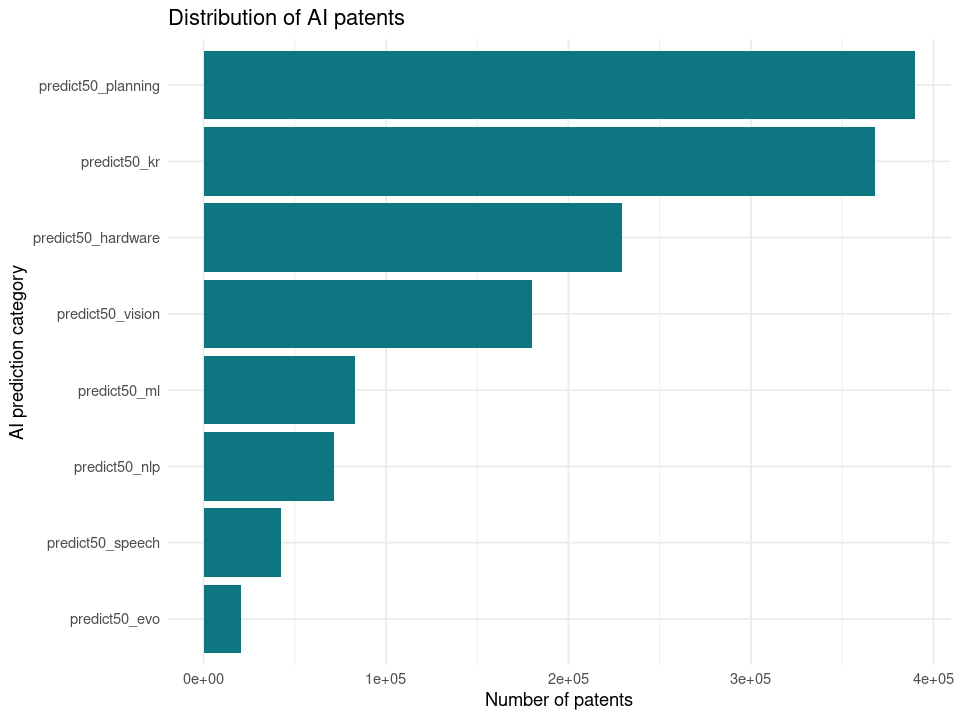

In [37]:
options(repr.plot.width=8, repr.plot.height=6, dpi=400)
aipatents %>%
    .[flag_patent == 1 & predict50_any_ai == 1] %>%
    # only keep rows that include 'predict50' in the column name
    # and doc_id, appl_id, and pub_dt
    .[, .SD, .SDcols = c('doc_id', 'appl_id', 'pub_dt', 
                            grep('predict50', names(.), value = TRUE))] %>%
    # melt the data
    melt(id.vars = c('doc_id', 'appl_id', 'pub_dt')) %>%
    setnames('variable', 'ai_predict') %>%
    .[ai_predict != 'predict50_any_ai'] %>%
    .[value == 1] %>%
    .[, .N, by = .(ai_predict)] %>%
    .[order(-N)] %>%
    # plot the distribution
    ggplot(aes(x = reorder(ai_predict, N), y = N)) +
    geom_bar(stat = 'identity', fill = ft_palette[2]) +
    coord_flip() +
    theme_minimal() +
    # title
    labs(title = 'Distribution of AI patents',
         x = 'AI prediction category',
         y = 'Number of patents')

Here is the full name of categories in the dataset:

- planning: AI planning, scheduling, and optimization
- kr: knowledge representation, reasoning, and processing
- hardware: AI hardware
- ml: machine learning
- vision: computer vision
- nlp: natural language processing
- speech: speech processing
- evo: evolutionary computation

## Trends in AI Invention

Now, we will analyze the trends in AI invention by counting the number of AI patents granted by the USPTO in each year for each category.

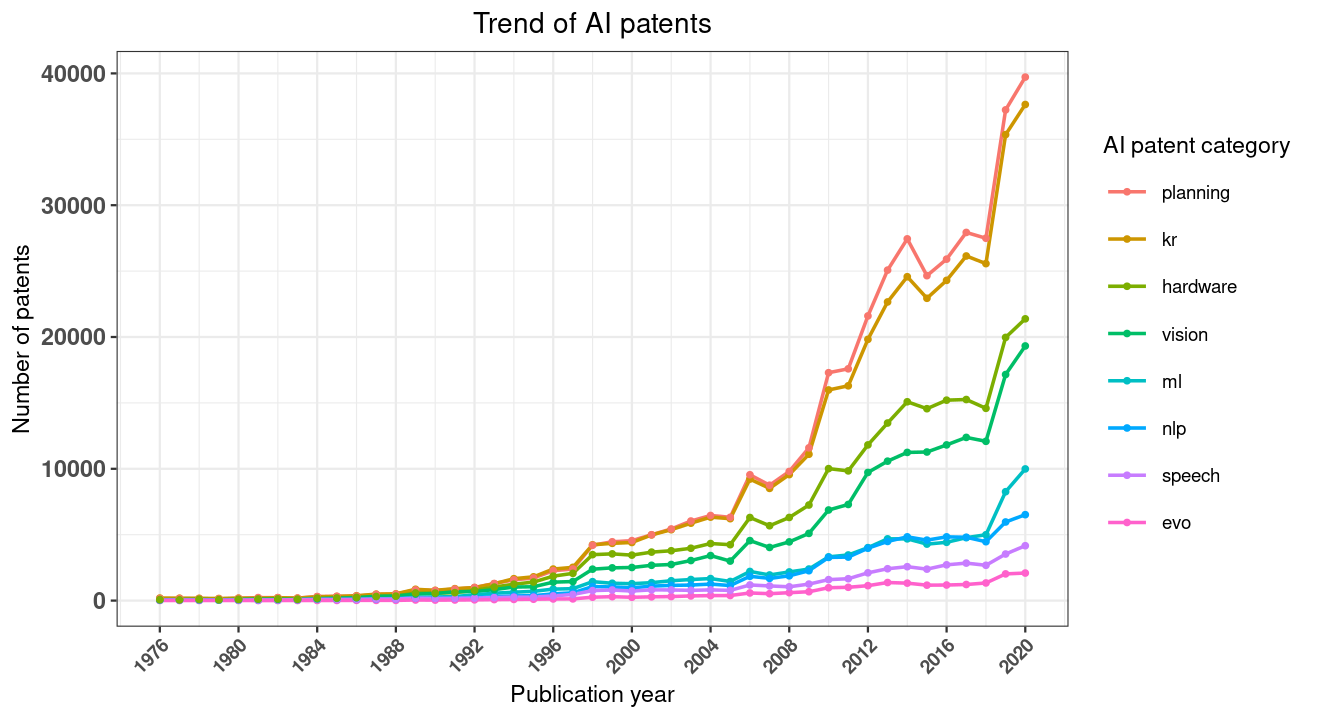

In [80]:
options(repr.plot.width=11, repr.plot.height=6, dpi = 800)
aipatents %>%
    .[flag_patent == 1 & predict50_any_ai == 1] %>%
    # only keep rows that include 'predict50' in the column name
    # and doc_id, appl_id, and pub_dt
    .[, .SD, .SDcols = c('doc_id', 'appl_id', 'pub_dt', 
                            grep('predict50', names(.), value = TRUE))] %>%
    # get year from pub_dt, pub_dt is IDate
    .[, pub_year := as.numeric(format(pub_dt, '%Y'))] %>%
    # melt the data
    melt(id.vars = c('doc_id', 'appl_id', 'pub_year')) %>%
    setnames('variable', 'ai_predict') %>%
    .[ai_predict != 'predict50_any_ai'] %>%
    .[value == 1] %>%
    .[, .N, by = .(ai_predict, pub_year)] %>%
    .[order(-pub_year)] %>%
    # replace 'predict50_' with ''
    .[, ai_predict := gsub('predict50_', '', ai_predict)] %>%
    ggplot(aes(x = pub_year, y = N, color = reorder(ai_predict, -N))) +
    geom_line(size=1) +
    geom_point() +
    theme_bw(base_size=14) +
    # title
    labs(title = 'Trend of AI patents',
         x = 'Publication year',
         y = 'Number of patents',
         color = 'AI patent category') +
    theme(
        plot.title=element_text(hjust=0.5),
        axis.text.x=element_text(face='bold', angle=45, hjust=1),
        axis.text.y=element_text(size=14, face='bold'),
        strip.text.x=element_text(size=14),
        legend.key.size = unit(1, 'cm')
        ) +
    scale_x_continuous(breaks = seq(1976, 2024, 4))

In [8]:
# only focus on patents from 2012 to 2016
aipatents %>%
    .[flag_patent == 1 & predict50_any_ai == 1] %>%
    # only keep rows that include 'predict50' in the column name
    # and doc_id, appl_id, and pub_dt
    .[, .SD, .SDcols = c('doc_id', 'appl_id', 'pub_dt', 
                            grep('predict50', names(.), value = TRUE))] %>%
    # get year from pub_dt, pub_dt is IDate
    .[, pub_year := as.numeric(format(pub_dt, '%Y'))] %>%
    .[pub_year >= 2012 & pub_year <=2016] -> aipatents_2012_2016

In [9]:
# only 205,185 observations left
str(aipatents_2012_2016)

Classes ‘data.table’ and 'data.frame':	205185 obs. of  13 variables:
 $ doc_id            : chr  "8650542" "8346687" "8489524" "9213939" ...
 $ appl_id           : chr  "13072165" "12560921" "13084692" "13785216" ...
 $ pub_dt            : IDate, format: "2014-02-11" "2013-01-01" ...
 $ predict50_any_ai  : int  1 1 1 1 1 1 1 1 1 1 ...
 $ predict50_ml      : int  0 0 1 1 0 0 0 0 1 1 ...
 $ predict50_evo     : int  0 0 0 0 0 0 0 0 0 0 ...
 $ predict50_nlp     : int  1 0 0 0 0 0 0 0 0 0 ...
 $ predict50_speech  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ predict50_vision  : int  0 1 0 0 1 0 0 1 1 0 ...
 $ predict50_kr      : int  1 1 1 1 1 1 1 0 1 0 ...
 $ predict50_planning: int  1 0 1 1 0 0 0 0 1 0 ...
 $ predict50_hardware: int  1 1 0 1 1 0 0 0 1 0 ...
 $ pub_year          : num  2014 2013 2013 2015 2012 ...
 - attr(*, ".internal.selfref")=<externalptr> 


## Who is the AI leader?

We have the dataset that only include application number, therefore we need to use the application number to find the assignee name. We will use the assignee name to identify the AI leader.

In [21]:
# randomly sample some patents
aipatents_2012_2016 %>%
    .[sample(.N, 5)] %>%
    head()

doc_id,appl_id,pub_dt,predict50_any_ai,predict50_ml,predict50_evo,predict50_nlp,predict50_speech,predict50_vision,predict50_kr,predict50_planning,predict50_hardware,pub_year
<chr>,<chr>,<IDate>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>
9289544,13519146,2016-03-22,1,0,0,0,0,0,1,0,0,2016
9237440,14084804,2016-01-12,1,0,0,0,0,0,1,1,1,2016
8529840,13601323,2013-09-10,1,0,0,0,0,0,1,1,0,2013
9195647,13802427,2015-11-24,1,0,0,1,0,1,1,1,1,2015
8428945,13105621,2013-04-23,1,1,0,0,0,1,1,1,0,2013


## Remarks

- For `doc_id` is of length 11, one should delete the zero after the year to search
it via EPO's Open Patent Services (OPS) API. For example, `doc_id` 20160167429 should be searched as 2016167429. Please add `US` before the `doc_id` to search as all the
patents are from the USPTO.
- The following code shows that the fifth character of the `doc_id` is all the same, which is zero for `doc_id` of length 11. Therefore, we can remove the fifth character to search the patent via EPO's OPS API.

In [32]:
# doc_id length == 11
aipatents %>%
    .[nchar(doc_id) == 11] %>%
    .[, .(doc_id)] %>%
    # get the fifth character of doc_id
    .[, doc_id_5 := substr(doc_id, 5, 5)] %>%
    .[doc_id_5 != '0'] %>%
    dim()

[1] 0 2

- For those patents that `doc_id` is not of length 11, one could search the patent directly by adding `US` before the `doc_id` to search as all the patents are from the
EPO's OPS API.

In [34]:
aipatents %>%
    .[nchar(doc_id) != 11] %>%
    # 6.9 million rows
    .[sample(.N, 5)] %>%
    head()

doc_id,flag_patent,pub_dt,appl_id,flag_train_any,predict50_any_ai,flag_train_ml,ai_score_ml,predict50_ml,flag_train_evo,⋯,flag_train_kr,ai_score_kr,predict50_kr,flag_train_planning,ai_score_planning,predict50_planning,flag_train_hardware,ai_score_hardware,predict50_hardware,analysis_phase
<chr>,<int>,<IDate>,<chr>,<int>,<int>,<int>,<dbl>,<int>,<int>,⋯,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>,<dbl>,<int>,<int>
9009788,1,2015-04-14,14011339,0,0,0,0.0009757876,0,0,⋯,0,6.866455e-05,0,0,0.0093754530,0,0,0.0237305164,0,1
8286348,1,2012-10-16,12234961,0,0,0,0.0001125336,0,0,⋯,0,1.382828e-04,0,0,0.0003275871,0,0,0.0001702309,0,1
4008222,1,1977-02-15,04602140,0,0,0,0.0007596016,0,0,⋯,0,7.579327e-04,0,0,0.0002980232,0,0,0.0005850792,0,1
9639512,1,2017-05-02,14549399,0,1,0,0.0020662546,0,0,⋯,0,5.351186e-03,0,0,0.0981565714,0,0,0.0204237700,0,1
7664027,1,2010-02-16,10969498,0,0,0,0.0098757744,0,0,⋯,0,2.750754e-04,0,0,0.0014713407,0,0,0.0045726895,0,1
